In [1]:
import h5py
# %matplotlib inline
%matplotlib notebook
import numpy as np
import sys
import time
import glob
from joblib import Parallel, delayed
import gc

sys.path.append('/home/ripper/kyle/pyVisOS/')

import osh5io
import osh5def
import osh5vis
import osh5utils
import osh5visipy
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.stats as st
from scipy.interpolate import RectBivariateSpline as RBS
from scipy.signal import hilbert

clrs=plt.rcParams['axes.prop_cycle'].by_key()['color'];
mpl.rcParams['font.serif'] = 'Latin Modern Roman'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'

Importing osh5visipy. Please use `%matplotlib notebook' in your jupyter/ipython notebook


In [2]:
def my_plot(data, os_data, window=20, title='', ax=None, clbl='', rlim=None, hilb=False, **kwargs):
    extent = [ os_data.axes[1].ax.min(), os_data.axes[1].ax.max(),
               -os_data.axes[0].ax.max(), os_data.axes[0].ax.max() ]
    dz = (os_data.axes[1].max - os_data.axes[1].min) / os_data.axes[1].size
    xlbl = osh5vis.axis_format(os_data.axes[1].attrs['LONG_NAME'], os_data.axes[1].attrs['UNITS'])
    ylbl = osh5vis.axis_format(os_data.axes[0].attrs['LONG_NAME'], os_data.axes[0].attrs['UNITS'])
    if ax==None:
        plt.imshow(data, extent=extent, aspect='auto', **kwargs)
        plt.xlabel(xlbl)
        plt.ylabel(ylbl)
        if rlim!=None:
            plt.ylim(-rlim,rlim)
        cb = plt.colorbar(pad=0.09)
        cb.set_label(clbl)
        plt.title(title)
        plt.autoscale(False)
        plt.twinx()
        if hilb:
            vals = np.abs(hilbert(data[data.shape[0]/2,:]))
            plt.plot(np.linspace(extent[0],extent[1],vals.size),vals,alpha=0.5,color='r')
            plt.ylabel('Hilbert envelope')
        else:
            weights = np.repeat(1.0, window)/window
            vals = np.convolve(data[data.shape[0]/2,:], weights, 'valid')
            plt.plot(np.linspace(extent[0]+dz*window/2,extent[1]-dz*window/2,vals.size),vals,alpha=0.5,color='r')
            plt.ylabel('Moving average')
        plt.ylim(top=vals.max()+1.4*(vals.max()-vals.min()))
    else:
        ax.imshow(data, extent=extent, aspect='auto', **kwargs)
        ax.set_xlabel(xlbl)
        ax.set_ylabel(ylbl)
        if rlim!=None:
            ax.ylim(-rlim,rlim)
        cb = ax.colorbar(pad=0.09)
        cb.set_label(clbl)
        ax.set_title(title)
        ax.autoscale(False)
        ax1=ax.twinx()
        if hilb:
            vals = np.abs(hilbert(data[data.shape[0]/2,:]))
            ax1.plot(np.linspace(extent[0],extent[1],vals.size),vals,alpha=0.5,color='r')
            ax1.set_ylabel('Hilbert envelope')
        else:
            weights = np.repeat(1.0, window)/window
            vals = np.convolve(data[data.shape[0]/2,:], weights, 'valid')
            ax1.plot(np.linspace(extent[0]+dz*window/2,extent[1]-dz*window/2,vals.size),vals,alpha=0.5,color='r')
            ax1.set_ylabel('Moving average')
        plt.ylim(top=vals.max()+1.4*(vals.max()-vals.min()))
        
# Use fancy scipy interpolation function – very slow
def interp_fields( x, interp, fld='e', calc=True ):
    if fld=='e':
        idx=0
    else: # fld=='b'
        idx=3
    
    flds = np.zeros((x.shape[0],3))
    if calc:
        for f in np.arange(3): # Go over field components
            # Add contributions from the 3 modes
            inds = x[:,3] <= rmax
            flds[inds,f] = interp[f+idx][0]( x[inds,3], x[inds,0], grid=False ) + \
                      ( interp[f+idx][1]( x[inds,3], x[inds,0], grid=False ) * x[inds,1] + \
                        interp[f+idx][2]( x[inds,3], x[inds,0], grid=False ) * x[inds,2] ) / x[inds,3]
    
    return flds

# Just use nearest grid to get the field, much faster
def interp_nearest( x, fields, e, b, n, ximax, rmax, dz, dr ):

    e[:] = 0.0
    b[:] = 0.0

    inds = np.logical_and( x[:,3] < rmax-dr/2, np.logical_and( x[:,4]<ximax-dz/2, x[:,4]>0.0 ) )

    i_r_ezp_br = (x[inds,3]/dr + 0.5).round().astype(int)
    i_r_er_bzp = (x[inds,3]/dr).round().astype(int)
    i_z_erp_bz = (x[inds,4]/dz).round().astype(int)
    i_z_ez_brp = (x[inds,4]/dz - 0.5).round().astype(int)

    x_r = x[inds,1]/x[inds,3]
    y_r = x[inds,2]/x[inds,3]
    x2_r2 = np.square(x_r)
    xy_r2 = x_r * y_r
    y2_r2 = np.square(y_r)
    
    # E first
    idx = 0
    # z component
    e[inds,0] = fields[0+idx,0,i_r_ezp_br,i_z_ez_brp] + \
                fields[0+idx,1,i_r_ezp_br,i_z_ez_brp] * x_r + \
                fields[0+idx,2,i_r_ezp_br,i_z_ez_brp] * y_r
    # x component
    e[inds,1] = fields[1+idx,0,i_r_er_bzp,i_z_erp_bz] * x_r - \
                fields[2+idx,0,i_r_ezp_br,i_z_erp_bz] * y_r + \
                fields[1+idx,1,i_r_er_bzp,i_z_erp_bz] * x2_r2 - \
                fields[2+idx,1,i_r_ezp_br,i_z_erp_bz] * xy_r2 + \
                fields[1+idx,2,i_r_er_bzp,i_z_erp_bz] * xy_r2 - \
                fields[2+idx,2,i_r_ezp_br,i_z_erp_bz] * y2_r2
    # y component
    e[inds,2] = fields[2+idx,0,i_r_ezp_br,i_z_erp_bz] * x_r + \
                fields[1+idx,0,i_r_er_bzp,i_z_erp_bz] * y_r + \
                fields[2+idx,1,i_r_ezp_br,i_z_erp_bz] * x2_r2 + \
                fields[1+idx,1,i_r_er_bzp,i_z_erp_bz] * xy_r2 + \
                fields[2+idx,2,i_r_ezp_br,i_z_erp_bz] * xy_r2 + \
                fields[1+idx,2,i_r_er_bzp,i_z_erp_bz] * y2_r2
                
    # B next
    idx = 3
    # z component
    b[inds,0] = fields[0+idx,0,i_r_er_bzp,i_z_erp_bz] + \
                fields[0+idx,1,i_r_er_bzp,i_z_erp_bz] * x_r + \
                fields[0+idx,2,i_r_er_bzp,i_z_erp_bz] * y_r
    # x component
    b[inds,1] = fields[1+idx,0,i_r_ezp_br,i_z_ez_brp] * x_r - \
                fields[2+idx,0,i_r_er_bzp,i_z_ez_brp] * y_r + \
                fields[1+idx,1,i_r_ezp_br,i_z_ez_brp] * x2_r2 - \
                fields[2+idx,1,i_r_er_bzp,i_z_ez_brp] * xy_r2 + \
                fields[1+idx,2,i_r_ezp_br,i_z_ez_brp] * xy_r2 - \
                fields[2+idx,2,i_r_er_bzp,i_z_ez_brp] * y2_r2
    # y component
    b[inds,2] = fields[2+idx,0,i_r_er_bzp,i_z_ez_brp] * x_r + \
                fields[1+idx,0,i_r_ezp_br,i_z_ez_brp] * y_r + \
                fields[2+idx,1,i_r_er_bzp,i_z_ez_brp] * x2_r2 + \
                fields[1+idx,1,i_r_ezp_br,i_z_ez_brp] * xy_r2 + \
                fields[2+idx,2,i_r_er_bzp,i_z_ez_brp] * xy_r2 + \
                fields[1+idx,2,i_r_ezp_br,i_z_ez_brp] * y2_r2

def dudt_boris( p_in, ep, bp ):

    tem = 0.5 * dt / rqm

    ep = ep * tem
    utemp = p_in + ep

    gam_tem = tem / np.sqrt( 1.0 + np.sum( np.square(utemp), axis=1 ) )

    bp = bp * np.tile(np.expand_dims(gam_tem,1),3)

    p_in[:,:] = utemp + np.cross(utemp,bp,axis=1)

    bp = bp * np.tile(np.expand_dims( 2.0 / ( 1.0 + np.sum( np.square(bp), axis=1 ) ), 1), 3)

    utemp = utemp + np.cross(p_in,bp,axis=1)

    p_in[:,:] = utemp + ep

def dudt_boris_e( p_in, ep ):

    tem = dt / rqm

    p_in = p_in + ep * tem
    
    return p_in

def dudt_boris_b( p_in, bp ):

    tem = 0.5 * dt / rqm

    utemp = p_in

    gam_tem = tem / np.sqrt( 1.0 + np.sum( np.square(utemp), axis=1 ) )

    bp = bp * np.tile(np.expand_dims(gam_tem,1),3)

    p_in = utemp + np.cross(utemp,bp,axis=1)

    bp = bp * np.tile(np.expand_dims( 2.0 / ( 1.0 + np.sum( np.square(bp), axis=1 ) ), 1), 3)

    p_in = utemp + np.cross(p_in,bp,axis=1)
    
    return p_in

def sim(x,p,T0,nmin,ximax,rmax,dt,dz,dr,i_prop,disp=0,perc_mod=5):
    # Run simulation
    n = 0
    print_percent = -1
    e = np.zeros((x.shape[0],3))
    b = np.zeros((x.shape[0],3))
    # print(x.shape[0])

    if disp==0: print("Running with T={}".format(T0))
    while n <= nmin or np.any(x[:,i_prop]>=-rmax):
        interp_nearest( x, fields, e, b, n, ximax, rmax, dz, dr )
        dudt_boris( p, e, b )
        rgamma = 1.0 / np.sqrt( 1.0 + np.sum( np.square(p), axis=1 ) )
        x[:,:3] = x[:,:3] + p * np.tile(np.expand_dims(rgamma*dt,1),3)
        x[:,3] = np.sqrt( np.square(x[:,1]) + np.square(x[:,2]) )
        x[:,4] = x[:,4] + p[:,0] * rgamma * dt - dt

        percent = np.round(n/nmin*100).astype(int)
        if percent%perc_mod==0 and percent > print_percent:
            if disp==0: print('{}%'.format(percent))
            print_percent = percent
        n += 1
        
    return x,p

def prep_fields( fldr, flds, mode_sub ):
    # Get and store r/z arrays to use with all fields
    data=osh5io.read_h5(glob.glob(fldr+'/e1*0-re*')[0])
    nr = data.axes[0].size
    nz = data.axes[1].size
    dr = (data.axes[0].max - data.axes[0].min) / nr
    dz = (data.axes[1].max - data.axes[1].min) / nz
    rmax = data.axes[0].max
    zmin = data.axes[1].min; zmax = data.axes[1].max

    # Get interpolation function for each component
    # interp = [] # will be interp[fld_type,mode]
    fields = np.zeros((len(flds),len(mode_sub),nr,nz))
    for i,fld in enumerate(flds):
        # interp.append([]) # Append empty list to get a sort of two-dimensional list
        for j,mode in enumerate(mode_sub):
            data=osh5io.read_h5(glob.glob('{}/{}_cyl_m-{}*'.format(fldr,fld,mode))[0])
            # Use data array with zeros on the edges to fix interpolation outside of accepted values
            # interp_data = np.zeros((r_interp.size,z_interp.size))
            # interp_data[:-1,1:-1] = data.values
            # interp[i].append(RBS(r_interp,z_interp,interp_data,kx=3,ky=3))
            fields[i,j,:,:] = data.values # Or just store it in this array since interpolation is slow

    mag_e_half = np.sqrt( np.sum( np.square( np.sum( fields[:3,:2,:,:], axis=1 ) ), axis=0 ) )
    size_x = 2*(mag_e_half.shape[0]-1)
    mag_e = np.zeros((size_x,mag_e_half.shape[1]))
    mag_e[size_x/2:,:] = mag_e_half[1:,:]
    mag_e[:size_x/2,:] = np.flip( mag_e_half[1:,:], axis=0 )
    mag_b_half = np.sqrt( np.sum( np.square( np.sum( fields[3:,:2,:,:], axis=1 ) ), axis=0 ) )
    mag_b = np.zeros((size_x,mag_b_half.shape[1]))
    mag_b[size_x/2:,:] = mag_b_half[1:,:]
    mag_b[:size_x/2,:] = np.flip( mag_b_half[1:,:], axis=0 )
    return dz, zmin, zmax, dr, rmax, fields, mag_e, mag_b

def plot_proton( c_wp, T_init, dist, x_all, i_trans, perc ):
    hist, edges = np.histogram(np.abs(x_all[:,i_trans]),bins=1500,normed=True)
    w_ind_r = np.argmax(np.cumsum(hist)*(edges[1]-edges[0])>perc)
    wind_r = edges[w_ind_r+1]

    hist, edges = np.histogram(x_all[:,0],bins=1500,normed=True)
    w_ind_u = np.argmax(np.cumsum(hist)*(edges[1]-edges[0])>perc)
    wind_u = edges[w_ind_u+1]
    w_ind_l = np.argmax(np.cumsum(np.flip(hist,axis=0))*(edges[1]-edges[0])>perc)
    wind_l = np.flip(edges,axis=0)[w_ind_l+1]

    vals = plt.hist2d(x_all[:,0],x_all[:,i_trans],bins=[np.linspace(wind_l,wind_u,220),
                                                 np.linspace(-wind_r,wind_r,220)],cmap='gray')
    cb=plt.colorbar(pad=0.09)
    cb.set_label('charge [a.u.]')
    plt.xlabel('$z$ [$c/\omega_p$]')
    plt.ylabel('$x$ [$c/\omega_p$]')
    plt.title('Radiograph at {} cm, $T={}$ MeV, $\sigma_x=${:.3f} [mm], $\sigma_z=${:.3f} [mm]'.format(dist,T_init,
                                                                                         np.std(x_all[:,i_trans])*c_wp*1e3,np.std(x_all[:,0])*c_wp*1e3))

def proton_pulse( c_wp, data, rmax, zmin, T_init, dist=2, perc=0.95 ):

    # Get correct data
    x=data['x']; p=data['p']
    i_prop=data['i_prop']; i_trans=data['i_trans']

    # Calculate positions at the screen
    d = -dist * 1e-2 / c_wp - rmax
    if np.any(x[:,i_prop]-d<0):
        d = np.min(x[:,i_prop])
    rgamma = 1.0 / np.sqrt( 1.0 + np.sum( np.square(p), axis=1 ) )
    t = ( d - x[:,i_prop] ) / ( p[:,i_prop] * rgamma )
    xfinal = x[:,:3] + p * np.tile(np.expand_dims(rgamma*t,1),3)
    # Add the zmin offset to align with the simulation data
    xfinal[:,0] = xfinal[:,0] + zmin

    plot_proton( c_wp, T_init, dist, xfinal, i_trans, perc )

sigma_T = 0.178352734147 w_p^-1


<IPython.core.display.Javascript object>


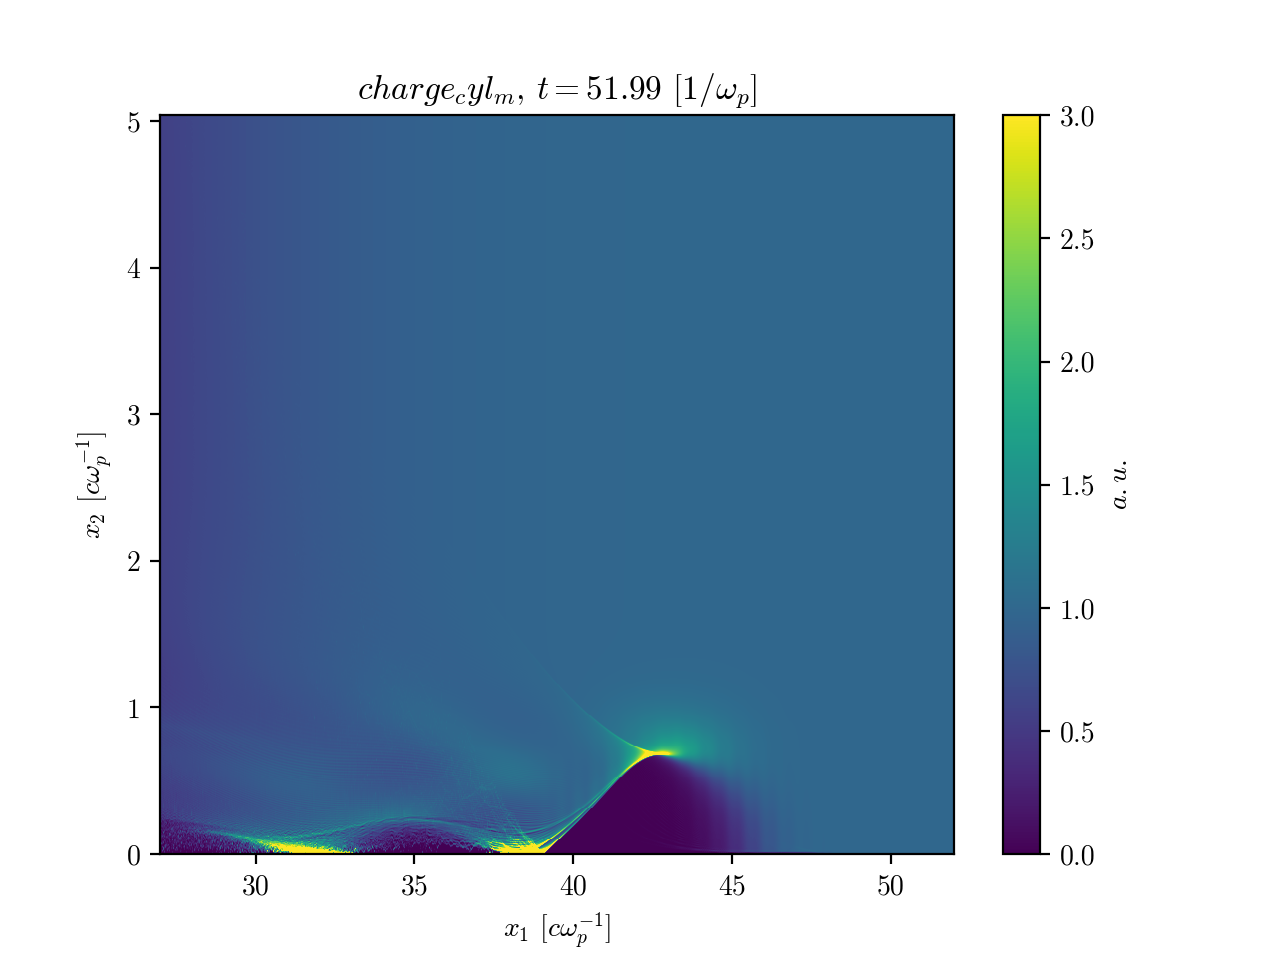

In [3]:
# Visualize plasma density first to get good idea of parameters:
f=osh5io.read_h5('q3d-n1e15-bubble-2/charge_cyl_m-electrons-0-re-000130.h5')
c=3e8
c_wp=np.load('q3d-n1e15-bubble-3/c_wp.npy')[0]
sigma_T=100e-15
print('sigma_T = {} w_p^-1'.format(sigma_T/c_wp*c))
plt.figure()
osh5vis.osplot(np.abs(f),vmax=3)
plt.show()

In [8]:
# Input parameters
prop = 'x' # Propagation direction is x or y
fldr = 'q3d-n1e15-bubble-2'
sigma_x0 = 1.0 # Standard deviation in transverse position of focused beam (sim units)
sigma_t0 = 100e-15 # Standard deviation in time of the beam
T0 = 55 # Initial temperature in MeV of the beam
M = 4 # Magnification of the beam at the screen
z_scr = 50 # Distance to screen in cm
std_t = 2.5 # Standard deviations in time to ensure pass through plasma
z_cutoff = False # Initialize particles with sharp cutoff in z (True) or as distribution (False)
std_z = 2.0 # Amount of standard deviations on one side of distro that fit into [zpmin,zpmax]
npart = int(1e7) # Total number of particles in the simulation
rqm = -1.0 # Mass to charge ratio of particles
dt_cell = 1.0 # fraction of a cell length to make dt

# Info that doesn't change
flds = ['e1','e2','e3','b1','b2','b3']
mode_sub = ['0-re','1-re','1-im']
c = 3e8
c_wp = np.load(fldr+'/c_wp.npy')[0]
npart_str = '{:1.0E}'.format(npart).replace('+','')
# Prepare the fields
dz, zmin, zmax, dr, rmax, fields, mag_e, mag_b = prep_fields( fldr, flds, mode_sub )
ximax = zmax - zmin
if prop == 'x':
    i_prop = 1
    i_trans = 2
elif prop == 'y':
    i_prop = 2
    i_trans = 1
else:
    print("prop needs to be either 'x' or 'y'")
    raise
if z_cutoff:
    suff = ''
else:
    suff = '_sigz'

# Convert inputs to simulation parameters
sigma_t0_ = sigma_t0*c/c_wp
p_temp = np.sqrt(T0/0.511)
gamma = np.sqrt(1+np.square(p_temp))
z_scr_ = z_scr*1e-2/c_wp/gamma
std_t_ = sigma_t0_ * std_t
dt = np.min([dz,dr]) * dt_cell # time step

# Calculate momentum spread in the transverse direction based on beam evolution
sigma_p0 = sigma_x0 * np.sqrt(np.square(M)-1) / z_scr_

# Initialize all transverse and longitudinal aspects of beam as if at center of plasma
x = np.zeros((npart,5)) # z,x,y,r,xi=z-t

# We choose a certain number of standard deviations in time that particles will actually go through the fields
# Outside of that, the particles will just end up free streaming
zpmin = -rmax - std_t_; zpmax = zmax - zmin + rmax + std_t_

if z_cutoff:
    x[:,0] = np.random.rand(npart) * (zpmax - zpmin) + zpmin # Initialize z spread across available range only
    sigma_pz0 = sigma_p0
else:
    # Alternatively, we can select a spread in z, just like we do in time
    sigma_z0 = (zpmax - zpmin) / std_z
    x[:,0] = np.random.normal( scale=sigma_z0, size=npart ) + (zpmax + zpmin) / 2
    sigma_pz0 = sigma_z0 * np.sqrt(np.square(M)-1) / z_scr_

x[:,i_trans] = np.random.normal( scale=sigma_x0, size=npart ) # Initialize transverse position
x[:,4] = x[:,0] - np.random.normal( scale=sigma_t0_, size=npart ) # Initialize the spread in time when particles are at center

# Initialize momentum; Gaussian in z and transversely, hot in propagation direction
print('Transverse momentum spread: {:.2f}%'.format(sigma_p0/p_temp*100))
print('Longitudinal momentum spread: {:.2f}%'.format(sigma_pz0/p_temp*100))
p = np.zeros((npart,3))
p[:,0] = np.random.normal( scale=sigma_pz0, size=npart )
p[:,i_trans] = np.random.normal( scale=sigma_p0, size=npart )
p[:,i_prop] = -p_temp

# We want to start all particles at x[:,i_prop] = r_max.  So we calculate how far to push particles back
rgamma = 1.0 / np.sqrt( 1.0 + np.sum( np.square(p), axis=1 ) )
t_push = rmax / (p[:,i_prop] * rgamma)
x[:,:3] = x[:,:3] + p * np.tile(np.expand_dims(rgamma*t_push,1),3)
x[:,4] = x[:,4] - t_push
x[:,3] = np.sqrt( np.square(x[:,1]) + np.square(x[:,2]) ) # Calculate r based on initial position

# Simulate particles crossing the plasma
nmin = 2*rmax / dt # Minimum number of time steps to traverse directly across the box
# sim(x,p,T0,nmin,ximax,rmax,dt,dz,dr,i_prop)
n_threads = 16
idx = (np.arange(n_threads+1)*npart)/n_threads
out=Parallel(n_jobs=n_threads,max_nbytes=None) \
(delayed(sim)(x[idx[i]:idx[i+1],:],p[idx[i]:idx[i+1],:],T0,nmin,ximax,rmax,dt,dz,dr,i_prop,
              disp=i-n_threads/2,perc_mod=5) for i in np.arange(n_threads))
for i, (xx,pp) in enumerate(out):
    x[idx[i]:idx[i+1],:]=xx
    p[idx[i]:idx[i+1],:]=pp
print('All done')

# Save output data to plot later if desired
np.savez('{}/data_{}_T_{}_M_{}_prop_{}{}'.format(fldr,npart_str,T0,M,prop,suff),x=x,p=p,sigma_x0=sigma_x0,sigma_t0=sigma_t0,
         T0=T0,M=M,z_scr=z_scr,std_t=std_t,npart=npart,rqm=rqm,dt_cell=dt_cell,i_prop=i_prop,i_trans=i_trans,
         z_cutoff=z_cutoff,std_z=std_z)

Transverse momentum spread: 0.13%
Longitudinal momentum spread: 2.35%


In [ ]:
# Input parameters, only sigz allowed, specify experimental parameters
prop = 'x' # Propagation direction is x or y
fldr = 'q3d-n1e15-bubble-2'
sigma_t0 = 100e-15 # Standard deviation in time of the beam
T0 = 55 # Initial temperature in MeV of the beam
z_scr = 0.50 # Distance to screen [m]
d_focus = np.array([0.7595, 0.8637]) # Distance of focus behind plasma, [m], [transverse,horizontal]
sigma_x0 = np.array([0.0416e-3, 0.0104e-3]) # Standard deviation in x,z [m]
beta_star = np.array([0.0711, 0.0039]) # Beta star value in x,z [m]
sigma_v0 = sigma_x0 / beta_star
npart = int(1e7) # Total number of particles in the simulation
rqm = -1.0 # Mass to charge ratio of particles
dt_cell = 1.0 # fraction of a cell length to make dt

# Info that doesn't change
flds = ['e1','e2','e3','b1','b2','b3']
mode_sub = ['0-re','1-re','1-im']
c = 3e8
c_wp = np.load(fldr+'/c_wp.npy')[0]
npart_str = '{:1.0E}'.format(npart).replace('+','')
# Prepare the fields
dz, zmin, zmax, dr, rmax, fields, mag_e, mag_b = prep_fields( fldr, flds, mode_sub )
ximax = zmax - zmin
if prop == 'x':
    i_prop = 1
    i_trans = 2
elif prop == 'y':
    i_prop = 2
    i_trans = 1
else:
    print("prop needs to be either 'x' or 'y'")
    raise
suff = '_exp'

# Convert inputs to simulation parameters
sigma_t0_ = sigma_t0*c/c_wp
sigma_x0_ = sigma_x0/c_wp
p_temp = np.sqrt(T0/0.511)
gamma = np.sqrt(1+np.square(p_temp))
# z_scr_ = z_scr/c_wp/gamma
d_focus_ = d_focus/c_wp
sigma_p0 = sigma_v0*gamma
print(sigma_p0/p_temp*100)
dt = np.min([dz,dr]) * dt_cell # time step

# Calculate momentum spread in the transverse direction based on beam evolution
# sigma_p0 = sigma_x0 * np.sqrt(np.square(Mx)-1) / z_scr_

# Initialize all transverse and longitudinal aspects of beam as if at center of plasma
x = np.zeros((npart,5)) # z,x,y,r,xi=z-t

# We choose a certain number of standard deviations in time that particles will actually go through the fields
# Outside of that, the particles will just end up free streaming
# zpmin = -rmax - std_t_; zpmax = zmax - zmin + rmax + std_t_

# Alternatively, we can select a spread in z, just like we do in time
# sigma_z0 = (zpmax - zpmin) / std_z
x[:,0] = np.random.normal( loc=(zmax - zmin)/2, scale=sigma_x0_[1], size=npart )
# sigma_pz0 = sigma_z0 * np.sqrt(np.square(Mz)-1) / z_scr_

x[:,i_trans] = np.random.normal( scale=sigma_x0_[0], size=npart ) # Initialize transverse position

# Initialize momentum; Gaussian in z and transversely, hot in propagation direction
# print('Transverse momentum spread: {:.2f}%'.format(sigma_p0/p_temp*100))
# print('Longitudinal momentum spread: {:.2f}%'.format(sigma_pz0/p_temp*100))
p = np.zeros((npart,3))
p[:,0] = np.random.normal( scale=sigma_p0[1], size=npart )
p[:,i_trans] = np.random.normal( scale=sigma_p0[0], size=npart )
p[:,i_prop] = -p_temp

# We want to start all particles at x[:,i_prop] = r_max.  So we calculate how far to push particles back
rgamma = 1.0 / np.sqrt( 1.0 + np.sum( np.square(p), axis=1 ) )
# We need to push the particles to the r=0 plane, but we have to do it separately for each dimension
# Calculate push time in transverse direction
t_push = (0 - d_focus_[0]) / (p[:,i_prop] * rgamma)
x[:,i_trans] = x[:,i_trans] + p[:,i_trans] * rgamma * t_push
# Next calculate push time in longitudinal direction
t_push = (0 - d_focus_[1]) / (p[:,i_prop] * rgamma)
x[:,0] = x[:,0] + p[:,0] * rgamma * t_push
# Calculate xi at this point
x[:,4] = x[:,0] - np.random.normal( scale=sigma_t0_, size=npart ) # Initialize the spread in time when particles are at center
# Next we push all particles back to rmax
t_push = rmax / (p[:,i_prop] * rgamma)
x[:,:3] = x[:,:3] + p * np.tile(np.expand_dims(rgamma*t_push,1),3)
x[:,4] = x[:,4] - t_push
x[:,3] = np.sqrt( np.square(x[:,1]) + np.square(x[:,2]) ) # Calculate r based on initial position

# Simulate particles crossing the plasma
nmin = 2*rmax / dt # Minimum number of time steps to traverse directly across the box
# sim(x,p,T0,nmin,ximax,rmax,dt,dz,dr,i_prop)
n_threads = 16
idx = (np.arange(n_threads+1)*npart)/n_threads
out=Parallel(n_jobs=n_threads,max_nbytes=None) \
(delayed(sim)(x[idx[i]:idx[i+1],:],p[idx[i]:idx[i+1],:],T0,nmin,ximax,rmax,dt,dz,dr,i_prop,
              disp=i-n_threads/2,perc_mod=5) for i in np.arange(n_threads))
for i, (xx,pp) in enumerate(out):
    x[idx[i]:idx[i+1],:]=xx
    p[idx[i]:idx[i+1],:]=pp
print('All done')

# Save output data to plot later if desired
np.savez('{}/data_{}_T_{}_prop_{}{}'.format(fldr,npart_str,T0,prop,suff),x=x,p=p,sigma_x0=sigma_x0,sigma_t0=sigma_t0,
         T0=T0,z_scr=z_scr,npart=npart,rqm=rqm,dt_cell=dt_cell,i_prop=i_prop,i_trans=i_trans,
         d_focus=d_focus,beta_star=beta_star,sigma_p0=sigma_p0)

In [ ]:
# Plot particles with new parameters
# Input parameters
fldr = 'q3d-n1e15-bubble-2'
npart = int(1e7)
T0 = 55
prop = 'x'
dists = [0,0.1,0.2,0.3,0.4,0.5,0.6,1,2,10,50] # distance to screen in cm

npart_str = '{:1.0E}'.format(npart).replace('+','')
c_wp = np.load(fldr+'/c_wp.npy')[0]
suff = '_exp'

dat_ele = osh5io.read_h5(glob.glob(fldr+'/charge*electrons*0-re*')[0])
size_x = 2*(dat_ele.shape[0]-1)
charge_e = np.zeros((size_x,dat_ele.shape[1]))
charge_e[size_x/2:,:] = dat_ele.values[1:,:]
charge_e[:size_x/2,:] = np.flip( dat_ele.values[1:,:], axis=0 )
dat_fld = osh5io.read_h5(glob.glob(fldr+'/e2*1-re*')[0])
fields = np.zeros_like(charge_e)
fields[size_x/2:,:] = dat_fld.values[1:,:]
fields[:size_x/2,:] = np.flip( dat_fld.values[1:,:], axis=0 )

rmax = dat_ele.axes[0].max
zmin = dat_ele.axes[1].min

plt.figure(figsize=(7,3*(len(dists)+2)))
plt.subplot(len(dists)+2,1,1)
my_plot(fields,dat_fld,title='Laser field',cmap='seismic',rlim=None,hilb=True)
plt.subplot(len(dists)+2,1,2)
my_plot(np.abs(charge_e),dat_ele,title='Electron density',cmap='gray',rlim=None,vmin=0,vmax=3)

# Load in saved data
data=np.load('{}/data_{}_T_{}_prop_{}{}.npz'.format(fldr,npart_str,T0,prop,suff))

for i,dist in enumerate(dists):
    plt.subplot(len(dists)+2,1,3+i)
    proton_pulse( c_wp, data, rmax, zmin, T0, dist=dist, perc=0.95 )

plt.tight_layout()
plt.savefig('{}/radiography_density_{}_T_{}_prop_{}{}.png'.format(fldr,npart_str,T0,prop,suff),dpi=300)
plt.show()

In [ ]:
# Plot particles
# Input parameters
fldr = 'q3d-n1e15-bubble-2'
npart = int(1e7)
T0 = 55
M = 4
prop = 'x'
z_cutoff = False
dists = [0,0.1,0.2,0.3,0.4,0.5,0.6,1,2,10,50] # distance to screen in cm

npart_str = '{:1.0E}'.format(npart).replace('+','')
c_wp = np.load(fldr+'/c_wp.npy')[0]
if z_cutoff:
    suff = ''
else:
    suff = '_sigz'

dat_ele = osh5io.read_h5(glob.glob(fldr+'/charge*electrons*0-re*')[0])
size_x = 2*(dat_ele.shape[0]-1)
charge_e = np.zeros((size_x,dat_ele.shape[1]))
charge_e[size_x/2:,:] = dat_ele.values[1:,:]
charge_e[:size_x/2,:] = np.flip( dat_ele.values[1:,:], axis=0 )
dat_fld = osh5io.read_h5(glob.glob(fldr+'/e2*1-re*')[0])
fields = np.zeros_like(charge_e)
fields[size_x/2:,:] = dat_fld.values[1:,:]
fields[:size_x/2,:] = np.flip( dat_fld.values[1:,:], axis=0 )

rmax = dat_ele.axes[0].max
zmin = dat_ele.axes[1].min

plt.figure(figsize=(7,3*(len(dists)+2)))
plt.subplot(len(dists)+2,1,1)
my_plot(fields,dat_fld,title='Laser field',cmap='seismic',rlim=None,hilb=True)
plt.subplot(len(dists)+2,1,2)
my_plot(np.abs(charge_e),dat_ele,title='Electron density',cmap='gray',rlim=None,vmin=0,vmax=3)

# Load in saved data
data=np.load('{}/data_{}_T_{}_M_{}_prop_{}{}.npz'.format(fldr,npart_str,T0,M,prop,suff))

for i,dist in enumerate(dists):
    plt.subplot(len(dists)+2,1,3+i)
    proton_pulse( c_wp, data, rmax, zmin, T0, dist=dist, perc=0.95 )

plt.tight_layout()
plt.savefig('{}/radiography_density_{}_T_{}_M_{}_prop_{}{}.png'.format(fldr,npart_str,T0,M,prop,suff),dpi=300)
plt.show()

### Sanity check on beam parameters and beam spreading with distance

<IPython.core.display.Javascript object>


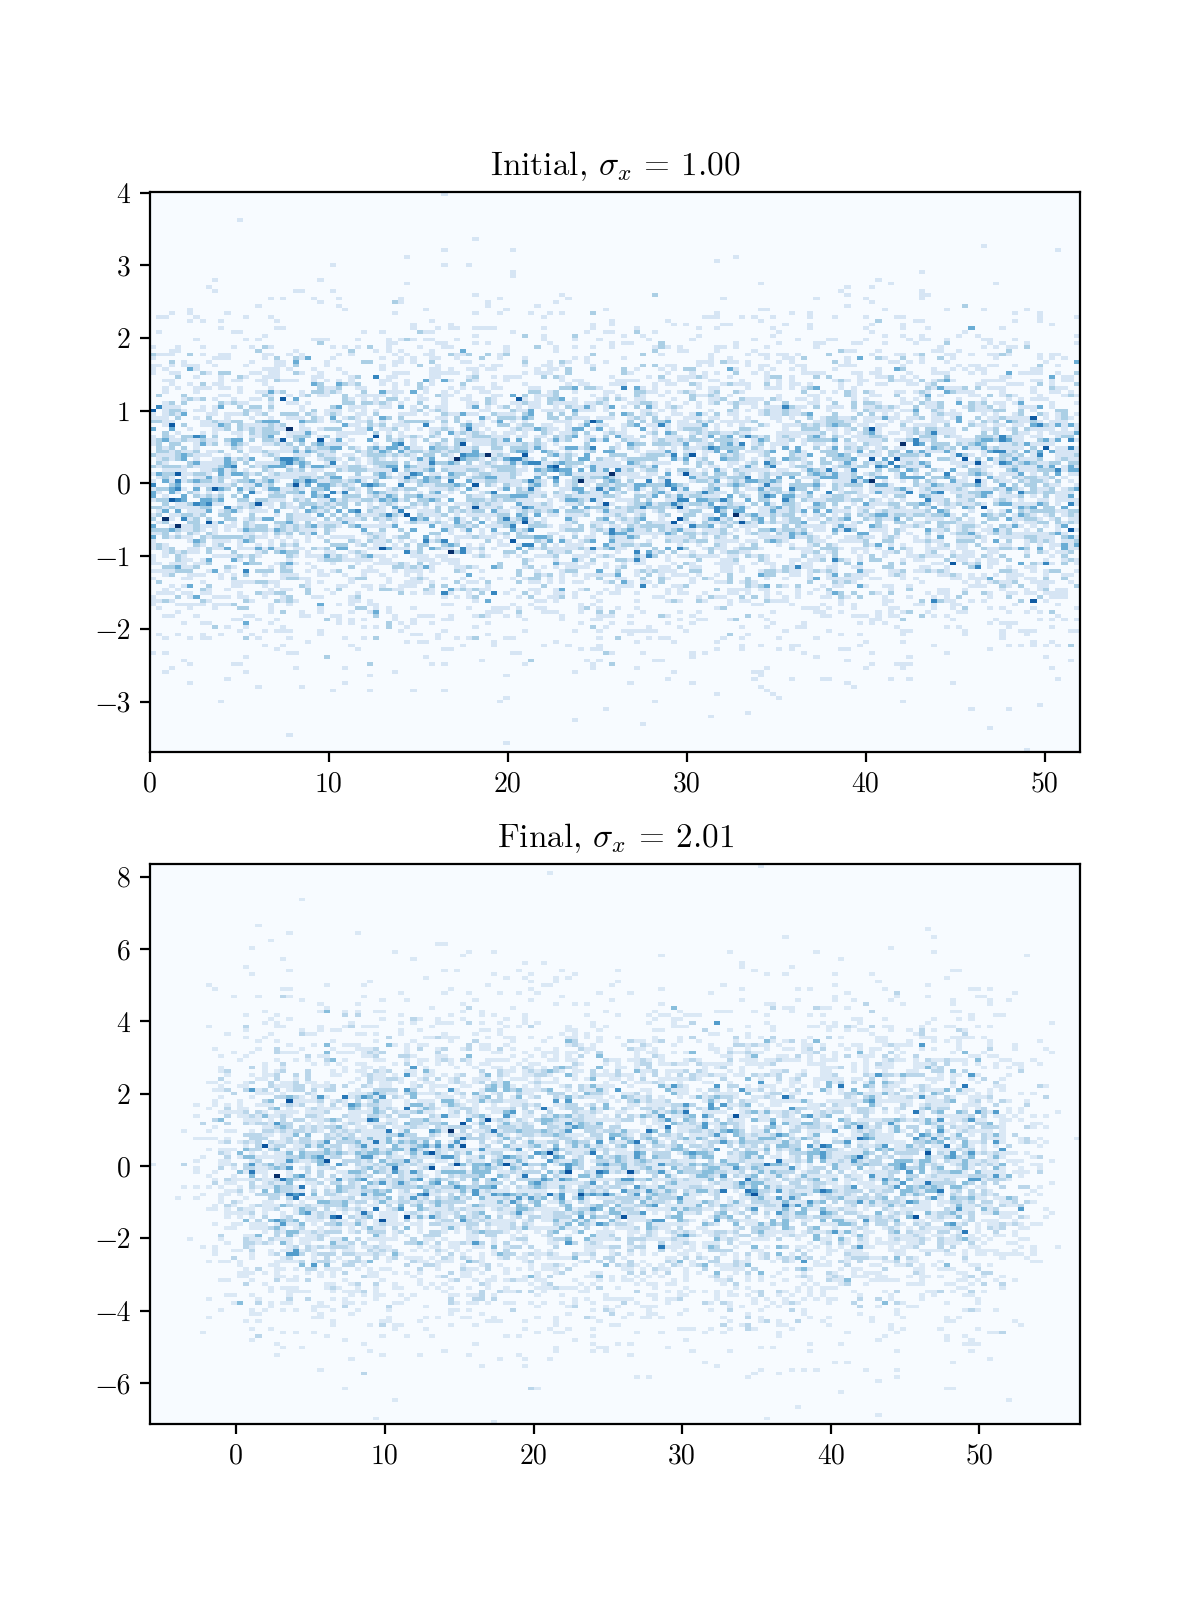

In [13]:
## Test a beam propagating without interacting with fields.  Just want to check if spread follows equation
# Input parameters
prop = 'x' # Propagation direction is x or y
fldr = 'q3d-n1e15-bubble-1'
sigma_x0 = 1.0 # Standard deviation in transverse position of focused beam (sim units)
T0 = 55 # Initial temperature in MeV of the beam
M = 2 # Magnification of the beam at the screen
z_scr = 50 # Distance to screen in cm
npart = int(1e4) # Total number of particles in the simulation

c = 3e8
c_wp = np.load(fldr+'/c_wp.npy')[0]
npart_str = '{:1.0E}'.format(npart).replace('+','')
# Prepare the fields
dz, zmin, zmax, dr, rmax, fields, mag_e, mag_b = prep_fields( fldr, flds, mode_sub )
ximax = zmax - zmin
if prop == 'x':
    i_prop = 1
    i_trans = 2
elif prop == 'y':
    i_prop = 2
    i_trans = 1
else:
    print("prop needs to be either 'x' or 'y'")
    raise

# Convert inputs to simulation parameters
p_temp = np.sqrt(T0/0.511)
gamma = np.sqrt(1+np.square(p_temp))
z_scr_ = z_scr*1e-2/c_wp/gamma

# Calculate momentum spread in the transverse direction based on beam evolution
sigma_p0 = sigma_x0 * np.sqrt(np.square(M)-1) / z_scr_

# Initialize all transverse and longitudinal aspects of beam as if at center of plasma
x = np.zeros((npart,5)) # z,x,y,r,xi=z-t
# We choose a certain number of standard deviations in time that particles will actually go through the fields
# Outside of that, the particles will just end up free streaming
zpmin = 0.0; zpmax = zmax
x[:,0] = np.random.rand(npart) * (zpmax - zpmin) + zpmin # Initialize z spread across available range
x[:,i_trans] = np.random.normal( scale=sigma_x0, size=npart ) # Initialize transverse position

# Initialize momentum; Gaussian in z and transversely, hot in propagation direction
p = np.zeros((npart,3))
p[:,0] = np.random.normal( scale=sigma_p0, size=npart )
p[:,i_trans] = np.random.normal( scale=sigma_p0, size=npart )
p[:,i_prop] = -p_temp

d = -z_scr * 1e-2 / c_wp
if np.any(x[:,i_prop]-d<0):
    print('changing')
    d = np.min(x[:,i_prop])
rgamma = 1.0 / np.sqrt( 1.0 + np.sum( np.square(p), axis=1 ) )
t = ( d - x[:,i_prop] ) / ( p[:,i_prop] * rgamma )
xfinal = x[:,:3] + p * np.tile(np.expand_dims(rgamma*t,1),3)

plt.figure(figsize=(6,8))
plt.subplot(211)
vals = plt.hist2d(x[:,0],x[:,i_trans],bins=150,cmap='Blues')
plt.title('Initial, $\sigma_x$ = {:.2f}'.format(np.std(x[:,i_trans])))
plt.subplot(212)
vals = plt.hist2d(xfinal[:,0],xfinal[:,i_trans],bins=150,cmap='Blues')
plt.title('Final, $\sigma_x$ = {:.2f}'.format(np.std(xfinal[:,i_trans])))
plt.show()

In [6]:
## Test a beam propagating without interacting with fields.  Just want to check if spread follows equation
# Input parameters
prop = 'x' # Propagation direction is x or y
fldr = 'q3d-n1e15-bubble-2'
sigma_x0 = 1.0 # Standard deviation in transverse position of focused beam (sim units)
sigma_p0 = 0.001 # Fraction of main momentum in transverse/longitudinal directions
sigma_t0 = 100e-15 # Standard deviation in time of the beam
T0 = 55 # Initial temperature in MeV of the beam
M = 4 # Magnification of the beam at the screen
z_scr = 50 # Distance to screen in cm
std_t = 2.5 # Standard deviations in time to ensure pass through plasma
std_z = 2.0 # Amount of standard deviations on one side of distro that fit into [zpmin,zpmax]
npart = int(1e6) # Total number of particles in the simulation
rqm = -1.0 # Mass to charge ratio of particles
dt_cell = 1.0 # fraction of a cell length to make dt

# Info that doesn't change
flds = ['e1','e2','e3','b1','b2','b3']
mode_sub = ['0-re','1-re','1-im']
c = 3e8
c_wp = np.load(fldr+'/c_wp.npy')[0]
npart_str = '{:1.0E}'.format(npart).replace('+','')
# Prepare the fields
dz, zmin, zmax, dr, rmax, fields, mag_e, mag_b = prep_fields( fldr, flds, mode_sub )
ximax = zmax - zmin
if prop == 'x':
    i_prop = 1
    i_trans = 2
elif prop == 'y':
    i_prop = 2
    i_trans = 1
else:
    print("prop needs to be either 'x' or 'y'")
    raise
suff = '_sigz'

# Convert inputs to simulation parameters
sigma_t0_ = sigma_t0*c/c_wp
p_temp = np.sqrt(T0/0.511)
gamma = np.sqrt(1+np.square(p_temp))
z_scr_ = z_scr*1e-2/c_wp/gamma
std_t_ = sigma_t0_ * std_t
dt = np.min([dz,dr]) * dt_cell # time step

# Initialize all transverse and longitudinal aspects of beam as if at center of plasma
x = np.zeros((npart,5)) # z,x,y,r,xi=z-t

# Initialize momentum; Gaussian in z and transversely, hot in propagation direction
sigma_p0 = sigma_p0 * p_temp
p = np.zeros((npart,3))
p[:,0] = np.random.normal( scale=sigma_p0, size=npart )
p[:,i_trans] = np.random.normal( scale=sigma_p0, size=npart )
p[:,i_prop] = -p_temp

# We choose a certain number of standard deviations in time that particles will actually go through the fields
# Outside of that, the particles will just end up free streaming
zpmin = -rmax - std_t_; zpmax = zmax - zmin + rmax + std_t_

# Select a spread in z, just like we do in time
sigma_z0 = (zpmax - zpmin) / std_z

# Get the distances to the plasma from the focus in the longitudinal/transverse directions,
# along with the spreads in x and z at the focus of the beam
zp_x_ = np.square(sigma_x0/sigma_p0)*(np.square(M)-1) / (2*z_scr_) - z_scr_/2
zp_x = zp_x_ * gamma
sigma_x0_f = np.sqrt( np.square(sigma_x0) - np.square(sigma_p0*zp_x_) )
zp_z_ = np.square(sigma_z0/sigma_p0)*(np.square(M)-1) / (2*z_scr_) - z_scr_/2
zp_z = zp_z_ * gamma
sigma_z0_f = np.sqrt( np.square(sigma_z0) - np.square(sigma_p0*zp_z_) )

x[:,0] = np.random.normal( scale=sigma_z0_f, size=npart ) + (zpmax + zpmin) / 2 + p[:,0] * zp_z / p_temp
x[:,i_trans] = np.random.normal( scale=sigma_x0_f, size=npart ) + p[:,i_trans] * zp_x / p_temp

x[:,4] = x[:,0] - np.random.normal( scale=sigma_t0_, size=npart ) # Initialize the spread in time when particles are at center

d = -z_scr * 1e-2 / c_wp
if np.any(x[:,i_prop]-d<0):
    print('PROBLEM, changing screen distance')
    d = np.min(x[:,i_prop])
rgamma = 1.0 / np.sqrt( 1.0 + np.sum( np.square(p), axis=1 ) )
t = ( d - x[:,i_prop] ) / ( p[:,i_prop] * rgamma )
xfinal = x[:,:3] + p * np.tile(np.expand_dims(rgamma*t,1),3)

plt.figure(figsize=(6,8))
plt.subplot(211)
vals = plt.hist2d(x[:,0],x[:,i_trans],bins=150,cmap='Blues')
plt.title('Initial, $\sigma_x$ = {:.2f}'.format(np.std(x[:,i_trans])))
plt.subplot(212)
vals = plt.hist2d(xfinal[:,0],xfinal[:,i_trans],bins=150,cmap='Blues')
plt.title('Final, $\sigma_x$ = {:.2f}'.format(np.std(xfinal[:,i_trans])))
plt.show()

/home/ripper/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in sqrt
/home/ripper/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in sqrt


ValueError: scale < 0

In [61]:
zp_x_ = np.square(sigma_x0/sigma_p0)*(np.square(M)-1) / (2*z_scr_) - z_scr_/2
print(0,zp_x_,z_scr_/(M-1))

(0, 101.7262179952086, 95.066650134301526)


In [65]:
M=3.5
zp_z_ = np.square(sigma_z0/sigma_p0)*(np.square(M)-1) / (2*z_scr_) - z_scr_/2
print(0,zp_z_,z_scr_/(M-1))

(0, 59143.928993786081, 114.07998016116183)


In [70]:
M=4
zp_z_ = np.square(sigma_z0/1.85/p_temp*100)*(np.square(M)-1) / (2*z_scr_) - z_scr_/2
print(0,zp_z_,z_scr_/(M-1))

(0, 88.367753920485939, 95.066650134301526)


In [60]:
np.square(sigma_x0) - np.square(sigma_p0*zp_x_)

0.048962818003913777

In [43]:
sigma_p0

0.010374588856116845

In [50]:
print(-z_scr_/(M+1),z_scr_/(M-1))

(-57.039990080580914, 95.066650134301526)


In [56]:
print(sigma_x0*(M-1)/z_scr_/p_temp*100, sigma_p0/p_temp*100, sigma_x0*(M+1)/z_scr_/p_temp*100)

(0.10139135204782117, 0.10000000000000001, 0.16898558674636865)


In [57]:
print(sigma_z0*(M-1)/z_scr_/p_temp*100, sigma_p0/p_temp*100, sigma_z0*(M+1)/z_scr_/p_temp*100)

(1.8237415000858188, 0.10000000000000001, 3.0395691668096978)


In [9]:
print(sigma_z0*np.sqrt(np.square(M)-1)/z_scr_/p_temp*100, sigma_p0/p_temp*100, sigma_z0*(M+1)/z_scr_/p_temp*100)

(2.3544401525399028, 0.10000000000000001, 3.0395691668096978)


In [ ]:
# Input parameters, only sigz allowed, specify experimental parameters
prop = 'x' # Propagation direction is x or y
fldr = 'q3d-n1e15-bubble-1'
sigma_t0 = 100e-15 # Standard deviation in time of the beam
T0 = 55 # Initial temperature in MeV of the beam
z_scr = 0.50 # Distance to screen [m]
d_focus = np.array([0.7595, 0.8637]) # Distance of focus behind plasma, [m], [transverse,horizontal]
sigma_x0 = np.array([0.0416e-3, 0.0104e-3]) # Standard deviation in x,z [m]
beta_star = np.array([0.0711, 0.0039]) # Beta star value in x,z [m]
sigma_v0 = sigma_x0 / beta_star
npart = int(1e7) # Total number of particles in the simulation
rqm = -1.0 # Mass to charge ratio of particles
dt_cell = 1.0 # fraction of a cell length to make dt

# Info that doesn't change
flds = ['e1','e2','e3','b1','b2','b3']
mode_sub = ['0-re','1-re','1-im']
c = 3e8
c_wp = np.load(fldr+'/c_wp.npy')[0]
npart_str = '{:1.0E}'.format(npart).replace('+','')
# Prepare the fields
dz, zmin, zmax, dr, rmax, fields, mag_e, mag_b = prep_fields( fldr, flds, mode_sub )
ximax = zmax - zmin
if prop == 'x':
    i_prop = 1
    i_trans = 2
elif prop == 'y':
    i_prop = 2
    i_trans = 1
else:
    print("prop needs to be either 'x' or 'y'")
    raise
suff = '_exp'

# Convert inputs to simulation parameters
sigma_t0_ = sigma_t0*c/c_wp
sigma_x0_ = sigma_x0/c_wp
p_temp = np.sqrt(T0/0.511)
gamma = np.sqrt(1+np.square(p_temp))
# z_scr_ = z_scr/c_wp/gamma
d_focus_ = d_focus/c_wp
sigma_p0 = sigma_v0*gamma
print(sigma_p0/p_temp*100)
dt = np.min([dz,dr]) * dt_cell # time step

# Calculate momentum spread in the transverse direction based on beam evolution
# sigma_p0 = sigma_x0 * np.sqrt(np.square(Mx)-1) / z_scr_

# Initialize all transverse and longitudinal aspects of beam as if at center of plasma
x = np.zeros((npart,5)) # z,x,y,r,xi=z-t

# We choose a certain number of standard deviations in time that particles will actually go through the fields
# Outside of that, the particles will just end up free streaming
# zpmin = -rmax - std_t_; zpmax = zmax - zmin + rmax + std_t_

# Alternatively, we can select a spread in z, just like we do in time
# sigma_z0 = (zpmax - zpmin) / std_z
x[:,0] = np.random.normal( loc=(zmax - zmin)/2, scale=sigma_x0_[1], size=npart )
# sigma_pz0 = sigma_z0 * np.sqrt(np.square(Mz)-1) / z_scr_

x[:,i_trans] = np.random.normal( scale=sigma_x0_[0], size=npart ) # Initialize transverse position

# Initialize momentum; Gaussian in z and transversely, hot in propagation direction
# print('Transverse momentum spread: {:.2f}%'.format(sigma_p0/p_temp*100))
# print('Longitudinal momentum spread: {:.2f}%'.format(sigma_pz0/p_temp*100))
p = np.zeros((npart,3))
p[:,0] = np.random.normal( scale=sigma_p0[1], size=npart )
p[:,i_trans] = np.random.normal( scale=sigma_p0[0], size=npart )
p[:,i_prop] = -p_temp

# We want to start all particles at x[:,i_prop] = r_max.  So we calculate how far to push particles back
rgamma = 1.0 / np.sqrt( 1.0 + np.sum( np.square(p), axis=1 ) )
# We need to push the particles to the r=0 plane, but we have to do it separately for each dimension
# Calculate push time in transverse direction
t_push = (0 - d_focus_[0]) / (p[:,i_prop] * rgamma)
x[:,i_trans] = x[:,i_trans] + p[:,i_trans] * rgamma * t_push
# Next calculate push time in longitudinal direction
t_push = (0 - d_focus_[1]) / (p[:,i_prop] * rgamma)
x[:,0] = x[:,0] + p[:,0] * rgamma * t_push
# Calculate xi at this point
x[:,4] = x[:,0] - np.random.normal( scale=sigma_t0_, size=npart ) # Initialize the spread in time when particles are at center
# Next we push all particles back to rmax
t_push = rmax / (p[:,i_prop] * rgamma)
x[:,:3] = x[:,:3] + p * np.tile(np.expand_dims(rgamma*t_push,1),3)
x[:,4] = x[:,4] - t_push
x[:,3] = np.sqrt( np.square(x[:,1]) + np.square(x[:,2]) ) # Calculate r based on initial position

# Simulate particles crossing the plasma
nmin = 2*rmax / dt # Minimum number of time steps to traverse directly across the box
# sim(x,p,T0,nmin,ximax,rmax,dt,dz,dr,i_prop)
n_threads = 16
idx = (np.arange(n_threads+1)*npart)/n_threads
out=Parallel(n_jobs=n_threads,max_nbytes=None) \
(delayed(sim)(x[idx[i]:idx[i+1],:],p[idx[i]:idx[i+1],:],T0,nmin,ximax,rmax,dt,dz,dr,i_prop,
              disp=i-n_threads/2,perc_mod=5) for i in np.arange(n_threads))
for i, (xx,pp) in enumerate(out):
    x[idx[i]:idx[i+1],:]=xx
    p[idx[i]:idx[i+1],:]=pp
print('All done')

# Save output data to plot later if desired
np.savez('{}/data_{}_T_{}_prop_{}{}'.format(fldr,npart_str,T0,prop,suff),x=x,p=p,sigma_x0=sigma_x0,sigma_t0=sigma_t0,
         T0=T0,z_scr=z_scr,npart=npart,rqm=rqm,dt_cell=dt_cell,i_prop=i_prop,i_trans=i_trans,
         d_focus=d_focus,beta_star=beta_star,sigma_p0=sigma_p0)

[ 0.05878032  0.26790259]
Running with T=55
0%
5%
10%


In [ ]:
# Plot particles with new parameters
# Input parameters
fldr = 'q3d-n1e15-bubble-1'
npart = int(1e7)
T0 = 55
prop = 'x'
dists = [0,0.1,0.2,0.3,0.4,0.5,0.6,1,2,10,50] # distance to screen in cm

npart_str = '{:1.0E}'.format(npart).replace('+','')
c_wp = np.load(fldr+'/c_wp.npy')[0]
suff = '_exp'

dat_ele = osh5io.read_h5(glob.glob(fldr+'/charge*electrons*0-re*')[0])
size_x = 2*(dat_ele.shape[0]-1)
charge_e = np.zeros((size_x,dat_ele.shape[1]))
charge_e[size_x/2:,:] = dat_ele.values[1:,:]
charge_e[:size_x/2,:] = np.flip( dat_ele.values[1:,:], axis=0 )
dat_fld = osh5io.read_h5(glob.glob(fldr+'/e2*1-re*')[0])
fields = np.zeros_like(charge_e)
fields[size_x/2:,:] = dat_fld.values[1:,:]
fields[:size_x/2,:] = np.flip( dat_fld.values[1:,:], axis=0 )

rmax = dat_ele.axes[0].max
zmin = dat_ele.axes[1].min

plt.figure(figsize=(7,3*(len(dists)+2)))
plt.subplot(len(dists)+2,1,1)
my_plot(fields,dat_fld,title='Laser field',cmap='seismic',rlim=None,hilb=True)
plt.subplot(len(dists)+2,1,2)
my_plot(np.abs(charge_e),dat_ele,title='Electron density',cmap='gray',rlim=None,vmin=0,vmax=3)

# Load in saved data
data=np.load('{}/data_{}_T_{}_prop_{}{}.npz'.format(fldr,npart_str,T0,prop,suff))

for i,dist in enumerate(dists):
    plt.subplot(len(dists)+2,1,3+i)
    proton_pulse( c_wp, data, rmax, zmin, T0, dist=dist, perc=0.95 )

plt.tight_layout()
plt.savefig('{}/radiography_density_{}_T_{}_prop_{}{}.png'.format(fldr,npart_str,T0,prop,suff),dpi=300)
plt.show()